In this post, I would like to give a shout out to this model [HighCWu/FLUX.1-dev-4bit](https://huggingface.co/HighCWu/FLUX.1-dev-4bit). The documentation made it very easy to adapt it to google colab with ControlNet, for control net we are going to be using [InstantX/FLUX.1-dev-Controlnet-Union](https://huggingface.co/InstantX/FLUX.1-dev-Controlnet-Union). This is a very comprehensive control net.


We start with cloning the repository.

In [ ]:
!git clone https://github.com/HighCWu/flux-4bit

Cloning into 'flux-4bit'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 2.71 MiB | 5.98 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/flux-4bit


We change the directory to the cloned repository and install the requirements.

In [ ]:
%cd flux-4bit

/content/flux-4bit


In [ ]:
!pwd

/content/flux-4bit


In [ ]:
!pip install -r requirements.txt

  Cloning https://github.com/mobiusml/hqq (to revision 306e30d) to /tmp/pip-install-xmig66_7/hqq_7c80ead43ccc48cca304499600c0fd50
  Running command git clone --filter=blob:none --quiet https://github.com/mobiusml/hqq /tmp/pip-install-xmig66_7/hqq_7c80ead43ccc48cca304499600c0fd50
  Running command git checkout -q 306e30d
  Resolved https://github.com/mobiusml/hqq to commit 306e30d
  Preparing metadata (setup.py) ... done
  Created wheel for hqq: filename=hqq-0.2.0-py3-none-any.whl size=63227 sha256=129b21554fd89cd682f89d65733e8c30e3889bf4b9fa6afea6d50649f88dca2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-jf_xnbp4/wheels/d7/24/e5/80b8980719b7af0f45c951c4e975ea67f64cd19eae065cd908
Successfully built hqq
  Attempting uninstall: hqq
    Found existing installation: hqq 0.2.2
    Uninstalling hqq-0.2.2:
      Successfully uninstalled hqq-0.2.2


At the time of writing this post, the diffusers official pip release doesn't have the ControlNet pipelines for flux, so we are going to take the code from the repository and install it.

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-c6_pqtwe
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-c6_pqtwe
  Resolved https://github.com/huggingface/diffusers.git to commit 7f323f0f3190533e596e09a4923dad1f73f23a91
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.31.0.dev0-py3-none-any.whl size=2799651 sha256=1e1dc888bbb905123c98a3bdd5a8c0e35518a26de74da35ff0efbbc6fe26fa83
  Stored in directory: /tmp/pip-ephem-wheel-cache-94rdv_s6/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.3
    Uninstalling diffusers-0.30.3:
      Successfully uninstalled diffusers-0.30.3


We need to run the model file since it contains custom definitions for the `T5EncoderModel` and `FluxTransformer2DModel`

In [ ]:
%run /content/flux-4bit/model.py

Now we import the required libraries and define the model for flux and also the control net.

In [ ]:
import torch

# from diffusers import FluxPipeline
from diffusers.utils import load_image
from diffusers import FluxControlNetPipeline, FluxControlNetModel

In [ ]:
text_encoder_2: T5EncoderModel = T5EncoderModel.from_pretrained(
    "HighCWu/FLUX.1-dev-4bit",
    subfolder="text_encoder_2",
    torch_dtype=torch.bfloat16,
    # hqq_4bit_compute_dtype=torch.float32,
)

transformer: FluxTransformer2DModel = FluxTransformer2DModel.from_pretrained(
    "HighCWu/FLUX.1-dev-4bit",
    subfolder="transformer",
    torch_dtype=torch.bfloat16,
)
controlnet = FluxControlNetModel.from_pretrained(
    'InstantX/FLUX.1-dev-Controlnet-Union',
    torch_dtype=torch.bfloat16
    )

pipe = FluxControlNetPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    text_encoder_2=text_encoder_2,
    controlnet=controlnet,
    transformer=transformer,
    torch_dtype=torch.bfloat16,
)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


For the free colab enviorment, we need to sue the `enable_model_cpu_offload()` function to run the model without consuming too much VRAM.

In [ ]:
pipe.enable_model_cpu_offload()

For the other colab environment, we can use the `pipe.to('cuda')` function to run the model on GPU.

In [ ]:
pipe.remove_all_hooks()
pipe.to('cuda')

FluxPipeline {
  "_class_name": "FluxPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "black-forest-labs/FLUX.1-dev",
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "__main__",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "__main__",
    "FluxTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Lets run a simple image generation task with a canny outlines images.

In [ ]:
control_image = load_image("https://huggingface.co/InstantX/FLUX.1-dev-Controlnet-Union-alpha/resolve/main/images/canny.jpg")
controlnet_conditioning_scale = 0.5
control_mode = 0

width, height = control_image.size

prompt = 'A realistic-style, raytraced, female travel blogger with sun-kissed skin and messy beach waves.'

image = pipe(
    prompt,
    control_image=control_image,
    control_mode=control_mode,
    width=width,
    height=height,
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    num_inference_steps=24,
    guidance_scale=3.5,
).images[0]
image.save("image.jpg")

  0%|          | 0/24 [00:00<?, ?it/s]

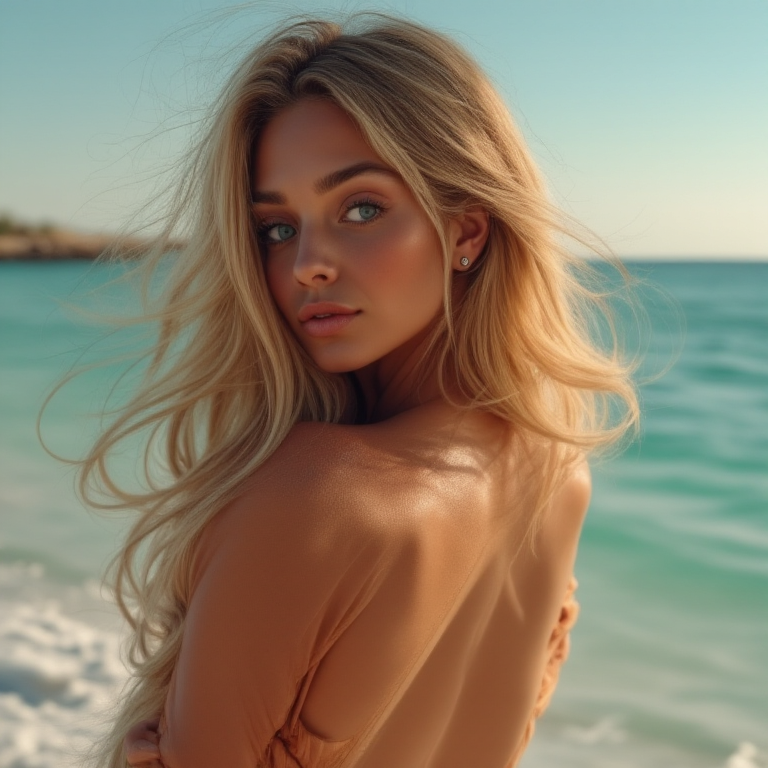

In [ ]:
image

## Conclusion
Flux with control net is a very powerful model, and we can use it for a variety of image generation tasks. Feel free to follow me on social media for more updates and posts.